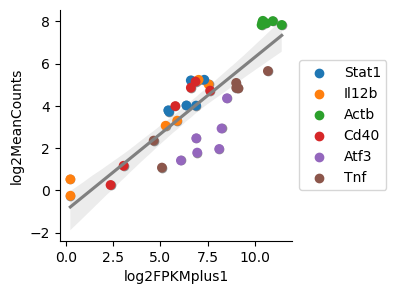

In [1]:
ENV["Code"] = "../../Code"
[push!(LOAD_PATH, string(ENV["Code"],"/", ii)) for ii in readdir(ENV["Code"])]

using DataFrames
using Seaborn
using NoLongerProblems_Pandas
using NoLongerProblems
using CSV
using RCall
import Pandas
using PrettyPlotting
using NoLongerProblems_Pandas

include("../Databases/Cuartero2018.jl")

fpkm = Cuartero2018.get_mean_FPKM();

tab = CSV.read("smFISH_MEAN.csv", DataFrames.DataFrame)
tab[!,:Sample_Gene] = tab[!,:Sample] .*"__".*tab[!,:Gene]

meantab = DataFrames.DataFrame(Sample_Gene = unique(tab[!,:Sample_Gene]))
meantab[!,:MeanCounts] = [mean(tab[tab[!,:Sample_Gene] .== ii, :MeanCounts]) for ii in meantab[!,:Sample_Gene]]
meantab[!,:Sample] = [split(ii, "__")[1] for ii in meantab[!,:Sample_Gene] ]
meantab[!,:Gene] = [split(ii, "__")[2] for ii in meantab[!,:Sample_Gene] ]

for name in names(fpkm)
    if startswith(string(name), "FL") 
      rename!(fpkm, Symbol(string(name))=>Symbol(replace(string(name), "FL"=> "Rad21KO")))
    end
end

fpkms = []
for ii in meantab[!,:Sample_Gene]
    samp = Symbol(split(ii, "__")[1])
    geneind = fpkm[!,:GeneSymbol].==split(ii, "__")[2]
     push!(fpkms, fpkm[geneind, samp][1])
end

meantab[!,:MeanFPKM] = fpkms


meantab[!,:log2MeanCounts] = log2.(meantab[!,:MeanCounts])
meantab[!,:log2FPKMplus1] = log2.(meantab[!,:MeanFPKM].+1)
pd = Pandas.DataFrame(meantab)
using PyCall
figure(figsize = (3, 3))
py"""
import seaborn as sns
sns.regplot(data = $pd, x = "log2FPKMplus1", y = "log2MeanCounts", color = "grey")
sns.scatterplot(data = $pd, x = "log2FPKMplus1", y = "log2MeanCounts", hue = "Gene", s = 50, linewidth = 0)

"""

pretty_axes2()
legend_out_of_plot()

PrettyPlotting.savefigwithtext("log2FPKM_log2MeanCounts.svg")


Correlation test (called from R)

In [2]:
R"""
tb <- $meantab
cor.test(tb$log2MeanCounts, tb$log2FPKM)
"""


RObject{VecSxp}

	Pearson's product-moment correlation

data:  tb$log2MeanCounts and tb$log2FPKM
t = 9.7105, df = 34, p-value = 2.462e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7361057 0.9252452
sample estimates:
      cor 
0.8573117 



In [3]:
new_df = DataFrames.DataFrame()

tab = CSV.read("smFISH_MEAN.csv", DataFrame)
tab[!,:Sample_Gene] = tab[!,:Sample] .*"__".*tab[!,:Gene]


rep1 = tab[tab[!,:Rep].== 1, [:Sample_Gene, :MeanCounts]]; rename!(rep1, :MeanCounts =>:Rep1)
rep2 = tab[tab[!,:Rep].== 2, [:Sample_Gene, :MeanCounts]]; rename!(rep2, :MeanCounts =>:Rep2)
rep3 = tab[tab[!,:Rep].== 3, [:Sample_Gene, :MeanCounts]]; rename!(rep3, :MeanCounts =>:Rep3)

reps = innerjoin(innerjoin(rep1, rep2, on =:Sample_Gene), rep3, on=:Sample_Gene)

reps[!,:Gene] = [split(ii, "__")[2] for ii in reps[!,:Sample_Gene] ]

set1 = ["Actb", "Il12b", "Stat1"]

exps1 = reps[[in(ii, set1) for ii in  reps[!,:Gene]], :]

exps2 = reps[[!in(ii, set1) for ii in  reps[!,:Gene]], :]

CSV.write("../SourceData/SupFig1c_meancountsset1.csv", exps1[!,["Rep1","Rep2","Rep3"]])
CSV.write("../SourceData/SupFig1c_meancountsset2.csv", exps2[!,["Rep1","Rep2","Rep3"]])



"../SourceData/SupFig1c_meancountsset2.csv"

In [4]:
R"""
library(devtools)
library(ggplot2)
library(GGally)

set1<-read.csv("cormatset1.csv")

g<- ggcorr(data = set1,label= 1)

ggsave("cormatset1.svg", width =2.5, height = 2.5)
g
"""

┌ Warning: RCall.jl: Loading required package: usethis
└ @ RCall /Users/irr15/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Registered S3 method overwritten by 'GGally':
│   method from   
│   +.gg   ggplot2
└ @ RCall /Users/irr15/.julia/packages/RCall/iMDW2/src/io.jl:160


LoadError: REvalError: Error in loadNamespace(x) : there is no package called ‘svglite’
Calls: ggsave ... loadNamespace -> withRestarts -> withOneRestart -> doWithOneRestart

In [5]:
R"""
set1<-read.csv("cormatset2.csv")

g<- ggcorr(data = set1,label= 1)

ggsave("cormatset2.svg", width =2.5, height = 2.5)
g
"""

LoadError: REvalError: Error in loadNamespace(x) : there is no package called ‘svglite’
Calls: ggsave ... loadNamespace -> withRestarts -> withOneRestart -> doWithOneRestart